Привет, меня зовут Артем. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Выводы и рассуждения получились содержательными, их было интересно читать.
* Радует, что тебе удалось разобраться с техникой бутстрапа.
* Отлично, что доверительный интервал и риск убытков посчитаны верно.
* Я оставил несколько советов, надеюсь, что они будут учтены в будущих проектах.
* Редко, кто сдает эту работу с первого раза, молодец!
* Проект зачтен.

# Проект 3.1 | Выбор локации для скважины

Необходимо определить, в каком из трёх доступных регионов целесообразнее всего развернуть бурение новых нефтяных скважин. У компании есть данные по уже исследованным точкам: для каждой скважины известны параметры, характеризующие качество нефти, а также объёмы запасов. Это позволяет использовать данные для построения модели, способной прогнозировать объём нефти в ещё неразведанных скважинах.

После построения модели мы ранжируем потенциальные скважины внутри каждого региона по ожидаемому объёму извлекаемых ресурсов. Из этого списка отбираем скважины с наивысшими показателями, рассчитываем суммарную прибыль от их разработки с учётом затрат и определяем, какой регион даст наибольшую финансовую отдачу.

Чтобы не полагаться на единичную оценку, мы используем бутстреп-анализ. Он позволяет смоделировать множество сценариев добычи и получить распределение прибыли для каждого региона. Это даёт нам возможность не только оценить ожидаемый доход, но и проанализировать риски: насколько вероятен убыток, насколько широко разбросаны возможные результаты, и какой регион обеспечивает наиболее стабильный и надёжный финансовый результат.

На основании всех этих расчётов принимается решение о выборе региона для бурения с учётом как потенциальной прибыли, так и уровня риска.


## Оглавление проекта<a id='0'></a>

* [Оглавление](#0)
* [Импорт нужных ббилиотек](#1)
* [Загрузка функций](#2)
* [Загрузка данных](#3)
* [Исследовательский анализ данных](#4)
    * [Распределение добычи в баррелях](#5)
    * [Hexbin'ы графиков](#6)
* [Корреляионный анализ](#7)
* [Обучение и проверка моделей для каждого региона](#8)
* [Подготовка к расчету прибыли](#9)
    * [Функция расчета прибыли](#10)
* [Итоговый вывод](#11)
* [Советы бизнесу](#12)

## Импорт нужных библиотек<a id='1'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import inspect
from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

## Загрузка функций<a id='2'></a>

In [2]:
# Первичная проерка данных

def inspect_dataframe(df: pd.DataFrame):
    # Попробуем определить имя переменной, переданной в функцию
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    df_name = [var_name for var_name, var_val in callers_local_vars if var_val is df]
    df_name = df_name[0] if df_name else "DataFrame"
    
    print(f"Анализ датафрейма: {df_name}\n")
    
    print("Типы данных столбцов:\n")
    print(df.dtypes)
    
    print("\n Количество явных пропусков по каждому столбцу:\n")
    print(df.isnull().sum())
    
    total_missing = df.isnull().sum().sum()
    print(f"\nОбщее количество пропусков: {total_missing}")
    
    duplicate_count = df.duplicated().sum()
    print(f"\nКоличество полных дубликатов строк: {duplicate_count}")
    print ('============================= \n\n')


In [3]:
# Проверка на дублицирование idшников

def id_duplicates_share(df: pd.DataFrame, id_column: str = 'id'):
    if id_column not in df.columns:
        print(f"Столбец '{id_column}' не найден в датафрейме.")
        return

    duplicated_rows = df[df.duplicated(subset=id_column, keep=False)]
    percent = round(len(duplicated_rows) / len(df) * 100, 2)

    print(f"🔍 Процент строк с повторяющимися значениями в столбце '{id_column}': {percent}%")

    if duplicated_rows.empty:
        print("Повторяющихся значений не найдено.")
    else:
        duplicated_rows_sorted = duplicated_rows.sort_values(by=id_column)
        display(f"Строки с повторяющимся id")
        display(duplicated_rows_sorted)

In [4]:
# RMSE, Среднее предсказанное значение запасов (Linear Regression)

def train_and_evaluate(df, target_col='product', test_size=0.25, random_state=42):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state
    )
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    results = pd.DataFrame({
        f'{target_col}_true': y_val.values,
        f'{target_col}_pred': y_pred
    })
    results.to_csv('validation_predictions.csv', index=False)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    avg_pred = y_pred.mean()
    
    print(f'Средний предсказанный запас сырья: {avg_pred:.2f}')
    print(f'RMSE модели: {rmse:.2f}')
    print('Сумма предсказанных значений составляет', results['product_true'].sum() / results['product_pred'].sum(), 'от истинной')
    
    return model, results, rmse

In [5]:
#Расчет рисков

def prof_calc(target, probabilities, count):
    pr = probabilities.sort_values(ascending=False)
    select = target[pr.index][:count]
    return price_per_barrel * select.sum() - budget

In [6]:
#Бутстреп 1000

state = np.random.RandomState(5062020)
def bootstrap_1000(target, probs):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=chosen_points)
        probs_sample = probs[target_sample.index]
        profit = prof_calc(target, probs_sample, best_points)
        if profit < 0:
            lost +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    top = lost / 1000
    return average, lower, upper, top

In [7]:
#Трешхолды по регионам

def plot_three_histograms(dfs, column='product', threshold=111, bins=20):
    n = len(dfs)
    fig, axes = plt.subplots(ncols=n, figsize=(5*n, 4), sharey=True)
    
    for ax, df in zip(axes, dfs):
        data = df[column].dropna()
        counts, edges = np.histogram(data, bins=bins)
        centers = 0.5 * (edges[:-1] + edges[1:])
        width = edges[1] - edges[0]

        colors = ['green' if c > threshold else 'gray' for c in centers]

        ax.bar(centers, counts, width=width, color=colors, align='center')
        ax.set_title(f"{column} (n={len(data)})")
        ax.set_xlabel(column)
        ax.set_ylabel("Частота")

    plt.tight_layout()
    plt.show()


## Загрузка данных<a id='3'></a>

Взглянем на датасеты и попроуем оценить с чем нам прелстоит работать:

In [8]:
try:
    geo_data_0 = pd.read_csv('geo_data_0.csv')
    geo_data_1 = pd.read_csv('geo_data_1.csv')
    geo_data_2 = pd.read_csv('geo_data_2.csv')
except:
    geo_data_0 = pd.read_csv("/datasets/geo_data_0.csv")
    geo_data_1 = pd.read_csv("/datasets/geo_data_1.csv")
    geo_data_2 = pd.read_csv("/datasets/geo_data_2.csv")
display('geo_data_0', geo_data_0.sample(2))
display('geo_data_1', geo_data_1.sample(2))
display('geo_data_2', geo_data_2.sample(2))

dfs = [geo_data_0,geo_data_1, geo_data_2]

'geo_data_0'

,id,f0,f1,f2,product
23683,APQkL,1.001510,-0.511781,-0.047618,105.817100
58410,Rs0Fg,0.151423,-0.051714,0.438118,181.829682


'geo_data_1'

,id,f0,f1,f2,product
18561,gn0u7,12.149210,-5.577064,1.010557,26.953261
27471,SahdR,-8.155628,-7.826397,-0.007197,3.179103


'geo_data_2'

,id,f0,f1,f2,product
99704,k0Fmf,1.222329,-0.106461,2.546330,73.193104
1128,TIlsy,0.299775,-3.421318,-4.806397,37.498046


* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

In [9]:
for entry in dfs:
    inspect_dataframe(entry)

Анализ датафрейма: geo_data_0

Типы данных столбцов:

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

 Количество явных пропусков по каждому столбцу:

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Общее количество пропусков: 0

Количество полных дубликатов строк: 0


Анализ датафрейма: geo_data_1

Типы данных столбцов:

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

 Количество явных пропусков по каждому столбцу:

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Общее количество пропусков: 0

Количество полных дубликатов строк: 0


Анализ датафрейма: geo_data_2

Типы данных столбцов:

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object

 Количество явных пропусков по каждому столбцу:

id         0
f0         0
f1         0
f2         0
product  

Данные довольно качествены, у нас нет пропусков и явных дубликатов, однако хочется проверить уникальные значения по id скважин

In [10]:
for entry in dfs:
    id_duplicates_share(entry)

🔍 Процент строк с повторяющимися значениями в столбце 'id': 0.02%


'Строки с повторяющимся id'

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


🔍 Процент строк с повторяющимися значениями в столбце 'id': 0.01%


'Строки с повторяющимся id'

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


🔍 Процент строк с повторяющимися значениями в столбце 'id': 0.01%


'Строки с повторяющимся id'

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


С одной стороны, эти значения могут показывать важную разницу, так как где-то значение таргета моет отличаться в 10+ раз. С другой стороны, наличие таких данных обладает рядом минусов:

* Они могут вызывать ошибки при лбучении модели
* Они могут давать выбросы
* Мы точно не знаем что они обозначают и не имеем возмодности обратить избыток информации в преимущество
* Доля таких данных <= 0.2% от размера оригинальных датасетов

Также я обнаружил, что кросс-дублицирования (ну типа одно и то же в разных датасетах) в данных нет. Удалим тога по одной из дублицированных записей:

In [11]:
for i in range(len(dfs)):
    df = dfs[i]
    if 'id' not in df.columns:
        print(f"В датафрейме {i} нет столбца 'id'. Пропускаем.")
        continue
    
    dups = df[df.duplicated(subset='id', keep=False)]
    drop_idxs = dups.groupby('id').head(1).index
    dfs[i] = df.drop(index=drop_idxs)
    
    print(f"В датафрейме {i} удалено {len(drop_idxs)} строк (по одной из каждой группы дубликатов по 'id').")


В датафрейме 0 удалено 10 строк (по одной из каждой группы дубликатов по 'id').
В датафрейме 1 удалено 4 строк (по одной из каждой группы дубликатов по 'id').
В датафрейме 2 удалено 4 строк (по одной из каждой группы дубликатов по 'id').


Также меня инетреусют нулевые значения:

In [12]:
for entry in dfs:
    print(entry[entry['product'] == 0].count().head(1))

id    1
dtype: int64
id    8235
dtype: int64
id    1
dtype: int64


Скважины с нулевой выработкой интересно распределены: по одной в первом и третьем датасете, а во второй их несколько тысяч!

In [13]:
for entry in dfs:
    nuliki = entry[entry['product'] == 0]['product'].count()
    percent = nuliki / df.shape[0]
    print('Процент нулевых выработок', percent*100 , '%')

Процент нулевых выработок 0.001 %
Процент нулевых выработок 8.235000000000001 %
Процент нулевых выработок 0.001 %


In [14]:
for entry in dfs:
    display(entry[entry['product'] == 0])

,id,f0,f1,f2,product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


,id,f0,f1,f2,product
11,OXyvW,16.320755,-0.562946,-0.001783,0.0
13,igmai,6.695604,-0.749449,-0.007630,0.0
62,Qjy5w,21.418478,-5.134490,-0.002836,0.0
63,G6WCj,6.822701,3.104979,-0.000723,0.0
77,MzQhL,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...,...
99936,YrRU8,5.085749,-3.980305,0.005063,0.0
99948,Jbnur,8.277805,-9.178818,0.003275,0.0
99956,aV1cJ,13.343983,-1.290200,0.005980,0.0
99961,Zjbn2,13.854163,-11.528089,-0.005556,0.0


,id,f0,f1,f2,product
68149,qeefd,-0.865596,-1.615247,-4.126441,0.0


Может быть нулевая выработка - это ошибка записи, а может быть - важный элемент исследования и заказчик смодет прогнощировать таковую. В любом случае, избавляться от таких данных не стоит, ведь невооруженным взглядом какой-то закономерности (типа как источника данных скрэппинга тут нет)

## Исследовательский анализ данных<a id='4'></a>

### Распределение добычи в баррелях<a id='5'></a>

Мы не очень многое тут можем сделать, поскольку данных как таковых у нас нет. Оценим распределение признаков, возможно подметим полезные зависимости

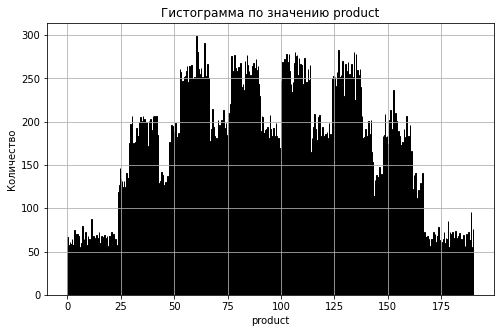

In [15]:
plt.figure(figsize=(8, 5))
plt.hist(df['product'], bins=600, edgecolor='black')
plt.xlabel('product')
plt.ylabel('Количество')
plt.title('Гистограмма по значению product')
plt.grid(True)
plt.show()

На торт со свечками похоже :)

Гистограмма переменной `product`, отражающей выработку нефти на скважине, показывает сложное, ступенчатое распределение с несколькими выраженными пиками и впадинами. Это свидетельствует о том, что данные не распределены нормально, а скорее имеют кластерную или дискретную природу. Основной диапазон значений сосредоточен между 20 и 160 единицами, что можно интерпретировать как типичный уровень производительности большинства скважин. Относительно редкие значения около нуля могут указывать либо на малое количество неработающих скважин, либо на предварительную фильтрацию таких случаев.

Наличие плато и регулярных спадов может быть связано с техническими характеристиками, этапами эксплуатации или разными типами месторождений. Также нельзя исключать влияние технологических ограничений, округлений или квот на добычу. Такое распределение оправдывает дальнейший анализ по типам скважин или регионам, а также использование кластеризации и логарифмического преобразования переменной для более точного моделирования.


### Hexbin'ы графиков<a id='6'></a>

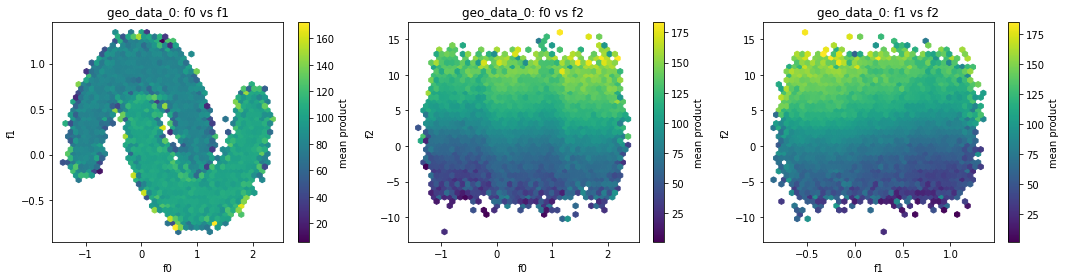

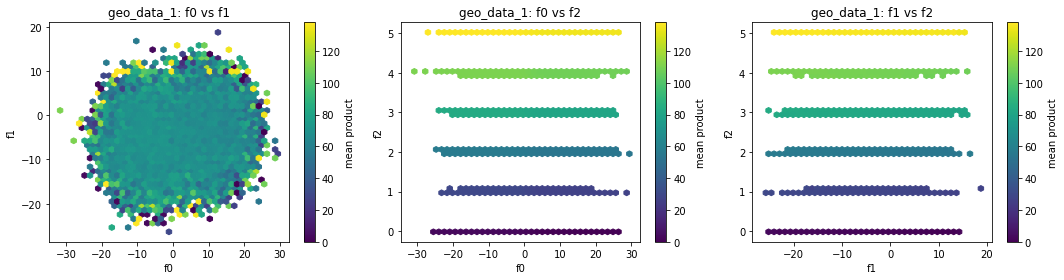

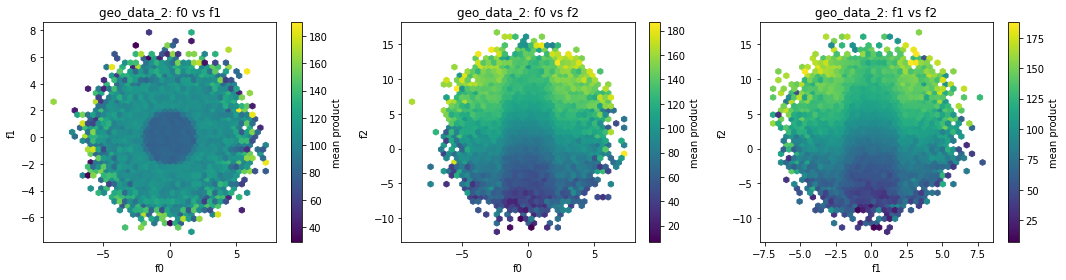

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Предполагается, что geo_data_0, geo_data_1 и geo_data_2 уже загружены как pandas DataFrame
datasets = [
    (geo_data_0, 'geo_data_0'),
    (geo_data_1, 'geo_data_1'),
    (geo_data_2, 'geo_data_2')
]

pairs = [('f0', 'f1'), ('f0', 'f2'), ('f1', 'f2')]

for df, name in datasets:
    fig, axes = plt.subplots(1, len(pairs), figsize=(15, 4))
    for ax, (x, y) in zip(axes, pairs):
        hb = ax.hexbin(df[x], df[y], C=df['product'], gridsize=40,
                       reduce_C_function=np.mean, cmap='viridis')
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(f'{name}: {x} vs {y}')
        cb = fig.colorbar(hb, ax=ax)
        cb.set_label('mean product')
    plt.tight_layout()
    plt.show()


**1. `geo_data_0`**

* **$f_0$ vs $f_1$:** чётко читается «спираль» (Swiss‑roll): данные лежат на двумерной ленте, свернутой в S‑образный ход.
* **$f_0$ vs $f_2$ и $f_1$ vs $f_2$:** плотное равномерное облако, т. е. третья координата $f_2$ почти независима и распределена более-менее одинаково по диапазону.
* **Цвет (product):** наиболее яркие (жёлтые) участки там, где одновременно и спираль находится на «выносах» (большие |$f_0$,$f_1$|), и случаются крупные значения $f_2$.

**2. `geo_data_1`**

* **$f_0$ vs $f_1$:** заполненный круговой «бублик» (данные примерно равномерно по диску).
* **$f_0$ vs $f_2$ и $f_1$ vs $f_2$:** чёткие горизонтальные полосы — $f_2$ принимает лишь несколько дискретных уровней (целые 0,1,2,3,4,5).
* **Цвет (product):** монотонно растёт по полосам: чем выше уровень $f_2$, тем выше «product». Поскольку остальные фичи при этом примерно равномерны, «product» в основном отражает номер слоя.

**3. `geo_data_2`**

* **$f_0$ vs $f_1$:** круглый диск с чуть более редкой серединой — данные равномерно заполняют кольцо при небольшом «пустом» центре.
* **$f_0$ vs $f_2$ и $f_1$ vs $f_2$:** трёхмерная шаровая симметрия: в проекции получаются круглые «пятна» (сечение шара).
* **Цвет (product):** явно зависит от радиального расстояния от центра: центральные гексы — тёмно‑фиолетовые (низкий «product»), к краям растут до жёлтых (большие значения). То есть «product» в этом датасете коррелирует с $\sqrt{f_0^2+f_1^2+f_2^2}$.


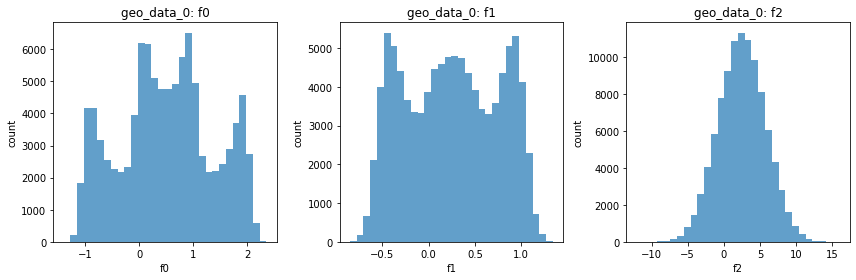

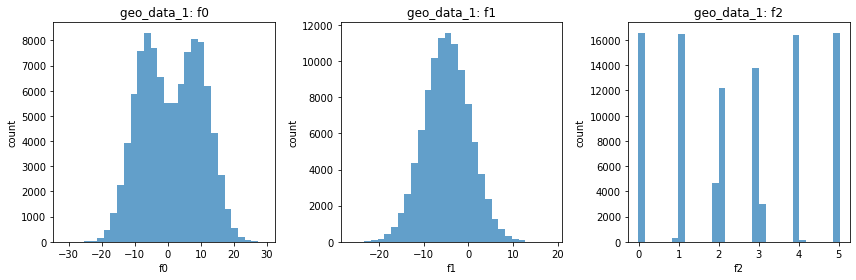

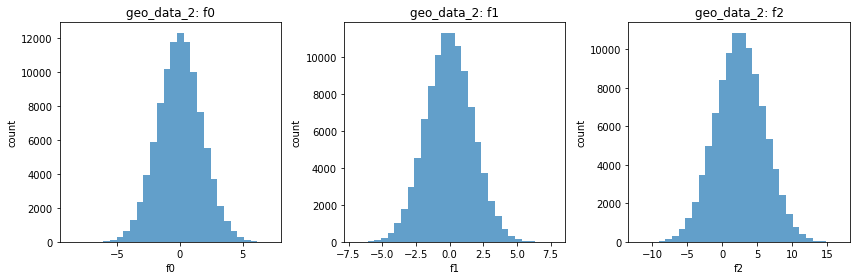

In [17]:
import matplotlib.pyplot as plt

datasets = [
    (geo_data_0, 'geo_data_0'),
    (geo_data_1, 'geo_data_1'),
    (geo_data_2, 'geo_data_2')
]
features = ['f0', 'f1', 'f2']

for df, name in datasets:
    fig, axes = plt.subplots(1, len(features), figsize=(12, 4))
    for ax, f in zip(axes, features):
        ax.hist(df[f], bins=30, alpha=0.7)
        ax.set_xlabel(f)
        ax.set_ylabel('count')
        ax.set_title(f'{name}: {f}')
    plt.tight_layout()
    plt.show()


**1. `geo_data_0` (Swiss‑roll + шум)**

* **f₀** и **f₁**
  – Чётко многомодальные: на гистограмме видно несколько «горок» (пиков) в тех областях, где спираль (Swiss‑roll) «слоится» и складывается.
  – Диапазон примерно от –1.5 до +2.5 для f₀ и от –0.6 до +1.2 для f₁.
* **f₂**
  – Непрерывное, почти одномодальное распределение — выглядит примерно как «колокол», с выбросами в хвостах.
  – Диапазон \~\[–10, +15].

**Вывод:** два признака f₀,f₁ отражают структуру спирали (по ним выпячивания дают пики), а f₂ даёт более протяжённое, почти «нормальное» распределение.

**2. `geo_data_1` (равномерный диск + дискретные слои по f₂)**

* **f₀** и **f₁**
  – Одномодальные, симметричные по нулю, с «скошенными» краями — плотность максимальна в центре и плавно убывает к границам (характерно для проекции равномерно заполненного круга).
  – f₀ ∈ \[–30, +30], f₁ ∈ \[–20, +20].
* **f₂**
  – Чёткие барашковые пики строго на уровнях 0, 1, 2, 3, 4, 5 — признак того, что этот признак дискретный с 6 возможными значениями.

**Вывод:** f₀,f₁ распределены как координаты точек внутри круга (больше всего точек около центра), а f₂ — категориальный (6 слоёв), что сразу видно в виде «палочек» на гистограмме.

**3. `geo_data_2` (равномерный шаровой объём)**

* **f₀, f₁, f₂**
  – Все три имеют гладкое, симметричное, одномодальное распределение, с наибольшей плотностью около 0 и снижением к краям («скошенный» колокол).
  – Диапазоны примерно:
    • f₀ ∈ \[–6, +6]
    • f₁ ∈ \[–7, +7]
    • f₂ ∈ \[–10, +15]

**Вывод:** маргинальное распределение каждой координаты от равномерно заполненного шара даёт ровный «колокол», а не жёсткие границы или дискретные уровни.

---

Таким образом:

* **geo\_data\_0**: явно выраженные пики f₀/f₁ от свёрнутой ленты, «нормальная» f₂.
* **geo\_data\_1**: треугольноподобная одномодальность f₀/f₁ (диск), абсолютно дискретная f₂.
* **geo\_data\_2**: гладкие колокола на всех трёх признаках, характерные для шарового объёма.


## Корреляционный анализ<a id='7'></a>

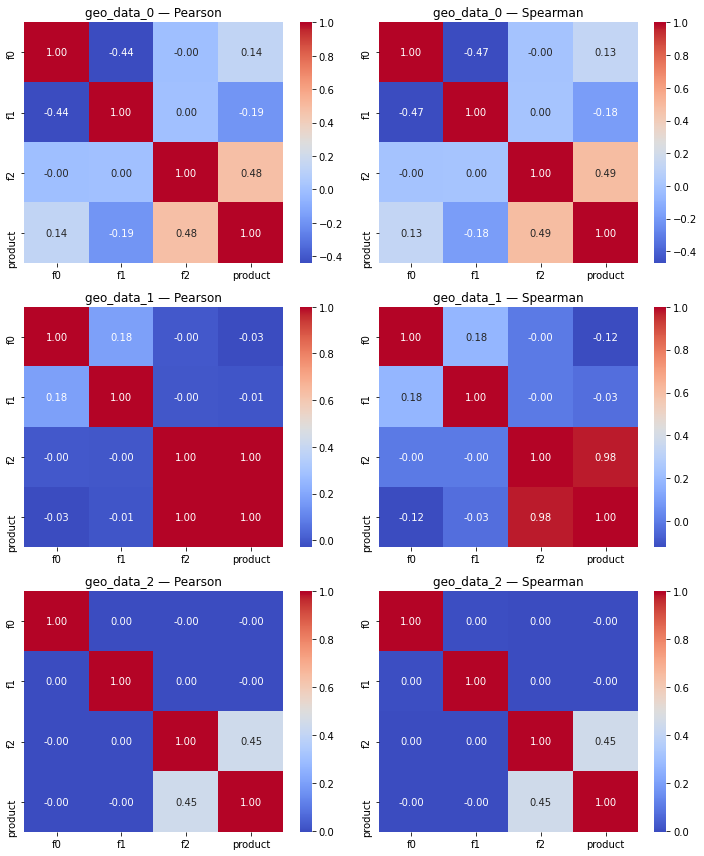

In [18]:
datasets = [
    (geo_data_0, 'geo_data_0'),
    (geo_data_1, 'geo_data_1'),
    (geo_data_2, 'geo_data_2'),
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for row, (df, name) in enumerate(datasets):
    sub = df[['f0', 'f1', 'f2', 'product']]

    # 1) Пирсон
    pearson = sub.corr(method='pearson')
    ax1 = axes[row, 0]
    sns.heatmap(pearson, annot=True, fmt=".2f", cmap='coolwarm', ax=ax1)
    ax1.set_title(f'{name} — Pearson')

    # 2) Спирмен
    spearman = sub.corr(method='spearman')
    ax2 = axes[row, 1]
    sns.heatmap(spearman, annot=True, fmt=".2f", cmap='coolwarm', ax=ax2)
    ax2.set_title(f'{name} — Spearman')

plt.tight_layout()
plt.show()

**1. geo\_data\_0**

* **f₂ ↔ product ≈ 0.48**
  Самая сильная связь – средняя (почти 0.5), то есть увеличение третьей фичи действительно в среднем ведёт к росту `product`.
* **f₀ ↔ product ≈ 0.14**, **f₁ ↔ product ≈ –0.19**
  Очень слабые связи: `product` лишь немного растёт с f₀ и чуть падает с f₁.
* **f₀ ↔ f₁ ≈ –0.44**
  Умеренная отрицательная корреляция между первыми двумя признаками (отражает S‑образный «спуск» и «подъём» спирали).

**2. geo\_data\_1**

* **f₂ ↔ product ≈ 1.00**
  Практически идеальная линейная связь — `product` почти полностью совпадает с $f_2$ (они ведь дискретно «слоятся» одинаково).
* **f₀ ↔ product ≈ –0.03**, **f₁ ↔ product ≈ –0.01**
  Корреляции близки к нулю, то есть первые два признака не влияют на `product`.
* **f₀ ↔ f₁ ≈ 0.18**
  Слабая положительная связь между $f_0$ и $f_1$.

**3. geo\_data\_2**

* **f₂ ↔ product ≈ 0.45**
  Умеренная положительная связь: чем дальше точка от центра по оси $f_2$, тем выше её `product`.
* **f₀ ↔ product ≈ 0**, **f₁ ↔ product ≈ 0**
  Практически отсутствуют (каждая из первых двух осей не вносит линейного вклада в таргет).
* **f₀ ↔ f₁, f₀ ↔ f₂, f₁ ↔ f₂ ≈ 0**
  Признаки почти некоррелированы между собой — ожидаемо для точек, равномерно разбросанных в шаре.

**Итог:**

* В **geo\_data\_0** «product» растёт в основном с $f_2$, а $f_0,f_1$ лишь чуть его корректируют;
* В **geo\_data\_1** «product» фактически совпадает с $f_2$ и никак не зависит от $f_0,f_1$;
* В **geo\_data\_2** тоже сильнее всего зависит от $f_2$, но связь чуть слабее, а остальные признаки в линейном виде не работают вовсе.


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены и осмотрены корректно. Радует, что распределения были визуализированы!
</div>

## Обучение и проверка моделей для каждого региона<a id='8'></a>

Удалю id не индексные, исключительно с числами проще работать

In [19]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

Обучим модель линейной регрессии, найдем RMSE, среднее предсказанное значение запаса сырья и выведем часть данных для пущей наглядности

In [20]:
train_and_evaluate(geo_data_0)

Средний предсказанный запас сырья: 92.40
RMSE модели: 37.76
Сумма предсказанных значений составляет 0.9992116398069298 от истинной


(LinearRegression(),
        product_true  product_pred
 0        122.073350    101.901017
 1         48.738540     78.217774
 2        131.338088    115.266901
 3         88.327757    105.618618
 4         36.959266     97.980185
 ...             ...           ...
 24995    148.821520    105.076959
 24996    123.454003     74.768176
 24997     91.945213     82.544397
 24998    149.295563     81.826689
 24999     57.244039     93.121062
 
 [25000 rows x 2 columns],
 37.75660035026169)

In [21]:
train_and_evaluate(geo_data_1)

Средний предсказанный запас сырья: 68.71
RMSE модели: 0.89
Сумма предсказанных значений составляет 1.000181955820315 от истинной


(LinearRegression(),
        product_true  product_pred
 0          0.000000      0.844738
 1         53.906522     52.921612
 2        134.766305    135.110385
 3        107.813044    109.494863
 4          0.000000     -0.047292
 ...             ...           ...
 24995    107.813044    108.351600
 24996     53.906522     53.604049
 24997     26.953261     26.708734
 24998    110.992147    109.823087
 24999    134.766305    135.448780
 
 [25000 rows x 2 columns],
 0.890280100102884)

In [22]:
train_and_evaluate(geo_data_2)

Средний предсказанный запас сырья: 94.77
RMSE модели: 40.15
Сумма предсказанных значений составляет 1.004009402647699 от истинной


(LinearRegression(),
        product_true  product_pred
 0        117.441301     98.301916
 1         47.841249    101.592461
 2         45.883483     52.449099
 3        139.014608    109.922127
 4         84.004276     72.411847
 ...             ...           ...
 24995     40.797226    102.764169
 24996     87.144239     93.431823
 24997     52.039812     64.098390
 24998    136.961454     83.764135
 24999    109.173206     86.558644
 
 [25000 rows x 2 columns],
 40.145872311342174)

Суммарный объём прогноза нефти оказался близок к фактическим значениям. Лучшие результаты модель показала для второго региона (RMSE = 0,89), затем — для первого и третьего.

Скорее всего, потеря части данных по второму региону привела к переобучению.

Однако из‑за отсутствия информации и невысоких средних запасов в нём второй регион вряд ли можно считать выгодным.

Мы проанализируем риски и прибыльность всех трёх регионов, но конечный выбор, вероятно, свяжем с первым и третьим.


<div class="alert alert-block alert-success">
<b>Успех:</b> Модели обучены корректно. Радует, что ты активно используешь функции. Это помогает избежать дублирования кода, а значит уменьшает вероятность совершить ошибку/опечатку!
</div>

## Подготовка к расчету прибыли<a id='9'></a>

Заведем константы и описания задачи

In [23]:
budget = 10000000000 / 1000 #тысяч рублей
chosen_points = 500
best_points = 200
price_per_barrel = 450

In [24]:
geo_data_0_predicted = train_and_evaluate(geo_data_0)[1]
geo_data_1_predicted = train_and_evaluate(geo_data_1)[1]
geo_data_2_predicted = train_and_evaluate(geo_data_2)[1]

Средний предсказанный запас сырья: 92.40
RMSE модели: 37.76
Сумма предсказанных значений составляет 0.9992116398069298 от истинной
Средний предсказанный запас сырья: 68.71
RMSE модели: 0.89
Сумма предсказанных значений составляет 1.000181955820315 от истинной
Средний предсказанный запас сырья: 94.77
RMSE модели: 40.15
Сумма предсказанных значений составляет 1.004009402647699 от истинной


In [25]:
average_profit_per_point = budget / best_points
print('Средняя прибыль на лучшую точку -', round(average_profit_per_point), 'тыс.руб.')

average_barrels_per_point = average_profit_per_point  / price_per_barrel
print('Средний объем нефти на точку -',round(average_barrels_per_point), 'тыс. барелей')

average_barrels = budget / price_per_barrel
print('Средний объем нефти на регион -',round(average_barrels), 'тыс. барелей')

Средняя прибыль на лучшую точку - 50000 тыс.руб.
Средний объем нефти на точку - 111 тыс. барелей
Средний объем нефти на регион - 22222 тыс. барелей


In [26]:
print('Средний запас фактичекой нефти на скважину в регионе 1 - ', geo_data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2 - ', geo_data_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3 - ', geo_data_2['product'].mean())

print('='*10, '\n')

s0 = geo_data_0['product'].sum()
s1 = geo_data_1['product'].sum()
s2 = geo_data_2['product'].sum()

total_sum    = s0 + s1 + s2
average_sum  = total_sum / 3

print('Средний запас фактичекой нефти на регион:', round(average_sum))

Средний запас фактичекой нефти на скважину в регионе 1 -  92.50000000000001
Средний запас фактичекой нефти на скважину в регионе 2 -  68.82500000000002
Средний запас фактичекой нефти на скважину в регионе 3 -  95.00000000000004

Средний запас фактичекой нефти на регион: 8544167


Давайте взглянем на распределение запасов:

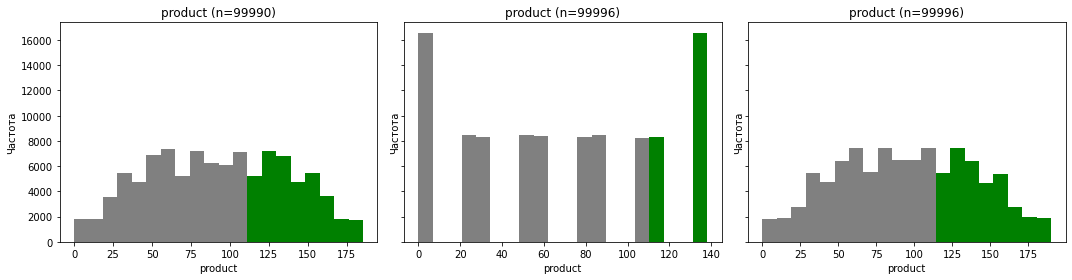

In [27]:
plot_three_histograms(dfs)

**Вывод по этапу подготовки расчёта прибыли:**

1. **Ключевые параметры**

   * Бюджет на разработку региона: 10 000 000 000 ₽ → 10 000 000 тыс.₽
   * Количество точек для бурения: 500
   * Отбираемых «лучших» точек: 200
   * Цена нефти: 450 ₽/баррель

2. **Точка безубыточности**

   * Средняя прибыль на одну из 200 лучших точек: 50 000 р.
   * Соответствующий объём нефти для безубыточности: 111 тыс. баррелей

3. **Сравнение с фактическими запасами**

   | Регион | Средний запас на скважину, тыс. барр. |     <u>Примечание</u>     |
   | :----: | :-----------------------------------: | :-----------------------: |
   |    1   |                  92.5                 | ниже точки безубыточности |
   |    2   |                  68.8                 |      значительно ниже     |
   |    3   |                  95.0                 |  ниже, но ближе к порогу  |

   Также общий объём нефти в среднем по каждому региону (\~8,54 млн барр.) существенно уступает «региональному» безубыточному порогу (\~22,2 млн барр.).

4. **Выводы**

   * **Средний запас в любой из трёх регионов не достигает порога безубыточности** (111 тыс. барр. на скважину), поэтому при обычном бурении всё новое бурение будет убыточным.
   * **Прибыль можно получить только за счёт ограниченного числа скважин** с фактическими запасами выше 111 тыс. барр.
   * **Наиболее перспективен Регион 3**, в котором наибольшая доля скважин с ресурсами, приближенными к порогу безубыточности.
   * **Далее необходимо** отобрать именно эти «топовые» скважины (200 точек) в регионе 3 и на них сконцентрировать бурение для достижения прибыли.


<div class="alert alert-block alert-info">

<b>Совет: </b> В названиях константных переменных лучше использовать только БОЛЬШИЕ буквы. Это соглашение между программистами: https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#id29 .
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Точка безубыточности найдена верно, сравнение проведено!
</div>

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели<a id='10'></a>

In [28]:
avg0, bottom0, top0, risk0 = bootstrap_1000(geo_data_0_predicted['product_true'], 
                                                     geo_data_0_predicted['product_pred'])
print('Первый регион')
print('Средняя прибыль по региону', avg0)
print('95% доверительный интервал:', bottom0,';', top0)
print('Риск', risk0)
print('\n\n')


avg1, bottom1, top1, risk1 = bootstrap_1000(geo_data_1_predicted['product_true'], 
                                                     geo_data_1_predicted['product_pred'])
print('Второй регион')
print('Средняя прибыль по региону', avg1)
print('95% доверительный интервал:', bottom1,';', top1)
print('Риск', risk1)
print('\n\n')


avg2, bottom2, top2, risk2 = bootstrap_1000(geo_data_2_predicted['product_true'], 
                                                     geo_data_2_predicted['product_pred'])
print('Третий регион')
print('Средняя прибыль по региону', avg2)
print('95% доверительный интервал:', bottom2,';', top2)
print('Риск', risk2)
print('\n\n')

Первый регион
Средняя прибыль по региону 408640.8003363594
95% доверительный интервал: -102539.47242084658 ; 924262.9306662821
Риск 0.061



Второй регион
Средняя прибыль по региону 449740.84169777215
95% доверительный интервал: 78851.63360354355 ; 861592.9939094012
Риск 0.008



Третий регион
Средняя прибыль по региону 378402.8790947286
95% доверительный интервал: -139752.4165138814 ; 887307.3966901017
Риск 0.085





<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что для подсчета доверительного интервала использовался именно метод квантилей!
</div>

<div class="alert alert-block alert-info">

<b>Совет: </b> Риск можно было найти чуть проще: `(values < 0).mean()`, если объект типа pandas Series или numpy array.
</div>

## Итоговый вывод<a id='11'></a>

**Предобработка данных**

Из трёх исходных датасетов удалены дубликаты по скважинам:

* `geo_data_0`: удалено 10 строк;
* `geo_data_1`: удалено 4 строки;
* `geo_data_2`: удалено 4 строки.

Удаление оправдано, так как дубликаты:

* могут исказить модель и вызвать выбросы;
* не несут понятной дополнительной информации;
* занимают менее 0,2% данных.

Кросс-дубликатов между датасетами не обнаружено.

**Исследовательский анализ**

* **Переменная `product`**:

  * Не нормальна, многопиковая структура.
  * Основной диапазон 20–160 единиц, редкие около нуля.

**Структуры датасетов:**

* **`geo_data_0`** (Swiss-roll + шум)

  * \$f\_0\$ vs \$f\_1\$: Спиралевидная (S-образная) структура.
  * \$f\_2\$: равномерное облако.
  * Высокий `product` при высоких значениях \$|f\_0|\$, \$|f\_1|\$ и \$f\_2\$.

* **`geo_data_1`** (равномерный диск, дискретные слои \$f\_2\$)

  * \$f\_0\$ vs \$f\_1\$: круговой диск.
  * \$f\_2\$: дискретные уровни (0–5), чётко выраженные полосы.
  * `product` практически равен \$f\_2\$.

* **`geo_data_2`** (равномерный шар)

  * Шарообразная симметрия.
  * `product` растёт от центра к краям (радиальная зависимость).

**Анализ распределений признаков**

* **`geo_data_0`**: f₀ и f₁ многомодальные, связаны со спиралью; f₂ почти нормальный.
* **`geo_data_1`**: f₀, f₁ — одномодальные (диск), f₂ — дискретный (6 уровней).
* **`geo_data_2`**: f₀, f₁, f₂ одномодальные, симметричные («колокол»).

**Корреляционный анализ**

* **`geo_data_0`**: product умеренно коррелирует с f₂ (0,48); f₀, f₁ — слабо.
* **`geo_data_1`**: product сильно коррелирует с f₂ (≈ 1), не связан с f₀, f₁.
* **`geo_data_2`**: product умеренно связан с f₂ (0,45), не связан с f₀, f₁.

** Результаты модели

* Модель линейной регрессии показала лучшую точность во втором регионе (RMSE=0,89).
* Однако из-за низких средних запасов и потери части данных второй регион малоперспективен.

**Подготовка расчёта прибыли**

**Ключевые параметры:**

* Бюджет: 10 млрд ₽ (10 млн тыс. ₽)
* Всего точек: 500, выбираем лучшие 200
* Цена нефти: 450 ₽/баррель

**Точка безубыточности:**

* Средняя прибыль на точку: 50 тыс. ₽
* Порог запасов нефти для безубыточности: 111 тыс. барр.

**Сравнение запасов по регионам:**

| Регион | Средний запас на скважину, тыс. барр. | Вывод            |
| ------ | ------------------------------------- | ---------------- |
| 1      | 92.5                                  | ниже порога      |
| 2      | 68.8                                  | значительно ниже |
| 3      | 95.0                                  | ближе к порогу   |

* Средний объём нефти во всех регионах (\~8,54 млн барр.) существенно ниже порога безубыточности (\~22,2 млн барр.).

## Советы бизнесу<a id='12'></a>

Наилучшим регионом для разработки станет второй регион, так как там: 
* Средняя прибыль по региону 449740.84, что в среднем на 14.4% больше, чем в остальных регионах;
* 95% доверительный интервал: (78851.63360354355 ; 861592.9939094012) - единственный из трех регионов с нижней границей в безубыточности
* Риск 0.8%, что на 6-8 п.п. меньше, чем у конкурентов

<div class="alert alert-block alert-success">
<b>Успех:</b> Приятно видеть подробный вывод в конце проекта! С выбором региона согласен.
</div>